- Gradient boosting is better than random forest.
- the best_params is not from the grid-search but from manual tries.
- Predicting cases:
    - cases is most important
    - adding other predictors increases accuracy
- predicting dases:
    - cases is still the most important
- early days v.s. recent days
    - accuracy is better for recent days prediction

## Predicting Early Day Cases

### Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../.')
from lib import get_data

../lib


In [2]:
df = get_data.get_model_data(date_range=(0,7), pred_day=10)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()

The get_model_data function

In [3]:
df.shape

(545, 67)

In [4]:
X = df.drop(['day_10_delta_cases','day_10_delta_deaths'], axis = 1)
y = df.day_10_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [6]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   54.4s finished


{'n_estimators': 10,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

In [7]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

Out-of-bag Accuracy: 0.5209
R-squared for Train: 0.94
R-squared for Test: 0.5568


Using randomized search for hyperparameter tuning, random forest regressor with the best parameters gave us R-square of 0.92 for taining set, and R-square of 0.57 for testing set. The model is overfitting quite a bit on the training set, but the selected parameters narrow down the search scope for further hyperparameter tuning.

In [11]:
param_grid = {'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3, 4],}

In [12]:
# n_estimators = 10 yields the best results
rf = RandomForestRegressor(n_estimators = 10, max_features = 'auto', max_depth = None, oob_score=True, random_state=109)
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
rf_gs.fit(X_train, y_train)

rf_gs.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 2}

In [13]:
rf = rf_gs.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))

y_pred = rf.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.6097
R-squared for Train: 0.91
R-squared for Test: 0.6360
Mean Absolute Error: 16.68 cases.


In [14]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.651731
14,mslPresMin,0.060055
16,mslPresMax,0.047257
18,presTendMin,0.040040
15,mslPresAvg,0.026125
61,grocery_and_pharmacy_percent_change_from_baseline,0.025442
64,pop_2018,0.022796
30,sfcPresMax,0.013855
45,windSpdMin,0.012022
1,deaths,0.011773


In [15]:
# predition with only cases
rf.fit(X_train.cases.values.reshape(-1,1), y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train.cases.values.reshape(-1,1), y_train))
print("R-squared for Test: %.2f" % rf.score(X_test.cases.values.reshape(-1,1), y_test))
y_pred = rf.predict(X_test.cases.values.reshape(-1,1))
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.3055
R-squared for Train: 0.69
R-squared for Test: 0.35
Mean Absolute Error: 24.2 cases.


### Gradient Boosting

In [16]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3]
}

gbr = GradientBoostingRegressor()
gs = GridSearchCV(estimator=gbr, param_grid=gb_hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'learning_rate': 0.2,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 500}

In [17]:
gbr = gs.best_estimator_
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.2, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=7,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.69
Mean Absolute Error: 18.25 cases.


In [19]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.575278
16,mslPresMax,0.069401
14,mslPresMin,0.068896
1,deaths,0.057286
64,pop_2018,0.035838
61,grocery_and_pharmacy_percent_change_from_baseline,0.030716
15,mslPresAvg,0.027672
18,presTendMin,0.021594
47,windSpdMax,0.018253
63,income_2018,0.009405


## Predicting Early Day Deaths

In [20]:
y = df.day_10_delta_deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

In [21]:
rf = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 8, 12], "n_estimators": [10, 50, 100, 200, 500, 1000]}
gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 1000}

In [22]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.2f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 0.69
R-squared for Test: 0.39
Mean Absolute Error: 47.85 cases.


In [23]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]


,variables,importance
0,cases,0.578822
1,deaths,0.091970
63,income_2018,0.018976
47,windSpdMax,0.016645
16,mslPresMax,0.014545
64,pop_2018,0.012734
60,transit_stations_percent_change_from_baseline,0.012216
19,presTendAvg,0.011010
17,precip,0.009732
18,presTendMin,0.009622


## Predicting Recent Day Cases

### random forest

In [24]:
df = get_data.get_model_data(date_range=(20,27), pred_day=30)
df = df._get_numeric_data().drop(['fips'],axis=1).dropna()
df.shape
# 30,37, 40 only leaves 20 rows

(215, 67)

In [25]:
X = df.drop(['day_30_delta_cases','day_30_delta_deaths'], axis = 1)
y = df.day_30_delta_cases

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
random_grid = {'max_depth': [1, 3, 5, None],
              'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2, 4, 8, 12],
             'n_estimators': [10, 50, 100, 200, 500]}

In [27]:
rf = RandomForestRegressor(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=109, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   43.2s finished


{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 3}

In [28]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)
print("Out-of-bag Accuracy: %.4f" % rf.oob_score_)
print("R-squared for Train: %.2f" % rf.score(X_train, y_train))
print("R-squared for Test: %.4f" % rf.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

Out-of-bag Accuracy: 0.6886
R-squared for Train: 0.88
R-squared for Test: 0.7356
Mean Absolute Error: 291.06 cases.


In [29]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.575278
16,mslPresMax,0.069401
14,mslPresMin,0.068896
1,deaths,0.057286
64,pop_2018,0.035838
61,grocery_and_pharmacy_percent_change_from_baseline,0.030716
15,mslPresAvg,0.027672
18,presTendMin,0.021594
47,windSpdMax,0.018253
63,income_2018,0.009405


### gradient boosting

In [30]:
# cases
gb_hyperparameters = {
    "n_estimators": [10, 50, 100, 200, 500, 1000],
    "min_samples_split" : [2, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    "min_samples_leaf": [1, 2, 3]
}

gbr = GradientBoostingRegressor()
gs = GridSearchCV(estimator=gbr, param_grid=gb_hyperparameters, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
gs = gs.fit(X_train, y_train)

gs.best_params_

{'learning_rate': 0.05,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 200}

In [31]:
gbr = gs.best_estimator_
gbr.fit(X_train, y_train)
print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 1.00
R-squared for Test: 0.79
Mean Absolute Error: 122.22 cases.


In [33]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.864778
64,pop_2018,0.016848
45,windSpdMin,0.016146
2,cldCvrMin,0.009784
17,precip,0.009782
1,deaths,0.008398
20,presTendMax,0.007504
46,windSpdAvg,0.006287
27,relHumMax,0.006070
39,windChillMin,0.004976


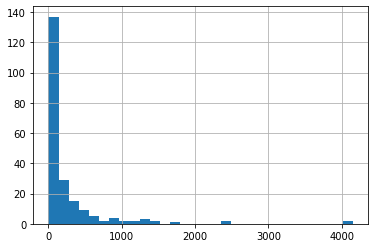

In [34]:
y.hist(bins = 30)

In [35]:
y.mean()

257.57674418604654

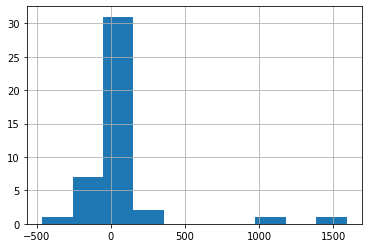

In [36]:
residuals = y_pred - y_test
residuals.hist()

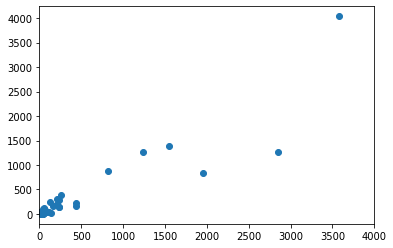

In [37]:
plt.scatter(x=y_pred, y = y_test)
#plt.yscale("log")
#plt.xscale("log")
plt.xlim([0,4000]);


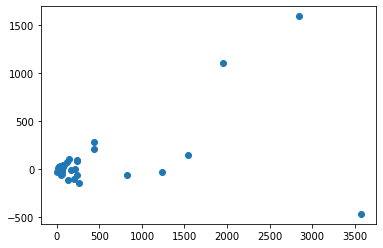

In [38]:
plt.scatter(x=y_pred, y = residuals)

## Recent Day Deaths

In [39]:
y = df.day_30_delta_deaths
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
gbr = GradientBoostingRegressor(learning_rate = 0.05, min_samples_leaf = 1, min_samples_split= 5, n_estimators = 100)
gbr.fit(X_train, y_train)

print("R-squared for Train: %.2f" % gbr.score(X_train, y_train))
print("R-squared for Test: %.2f" % gbr.score(X_test, y_test))
y_pred = gbr.predict(X_test)
# Calculate the absolute errors
mae = round(np.mean(abs(y_pred - y_test)),2)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'cases.')

R-squared for Train: 0.99
R-squared for Test: 0.66
Mean Absolute Error: 8.6 cases.


In [41]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variables']), 
           pd.DataFrame(gbr.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:10]

,variables,importance
0,cases,0.764054
1,deaths,0.082048
42,windDirAvg,0.024729
45,windSpdMin,0.023476
26,relHumAvg,0.018632
25,relHumMin,0.014998
63,income_2018,0.013048
17,precip,0.008491
48,windSpd80mMin,0.008171
14,mslPresMin,0.007068
